# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Explore correlations between the features and target classes
# Top 19 (18) selected features, fill NaN

Top 19 features without `pin_years_since_last_sale` and with NaN past/future xy sales filled with mean
future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [30]:
random_state = 1

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model

In [3]:
def targets_corr(df, target_list, target_var, plot_corr=True, print_top_coefs=True, print_top=10,
                 fig_height=4, fig_width=10, legend_loc='center right',
                 output='show', save_path='targets_corr.png', dpi=300, save_only=False):
    target0_corr = df.corr()[target_list[0]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target1_corr = df.corr()[target_list[1]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target2_corr = df.corr()[target_list[2]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
    target3_corr = df.corr()[target_list[3]].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

    all_targets_corr = pd.merge(
        pd.merge(
            pd.merge(target0_corr, target1_corr, on='var'),
            target2_corr, on='var'),
        target3_corr, on='var')
    target_list.append(target_var)
    mask1 = all_targets_corr['var'].isin(target_list)
    all_targets_corr = all_targets_corr[~mask1]
    targets_corr_tidy = pd.melt(all_targets_corr, id_vars='var').sort_values('var')

    if print_top_coefs:
        print("----- Pearson correlation coefficient between features and target classes"
              "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
              targets_corr_tidy.sort_values('value').head(print_top),
              "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
              targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

    if plot_corr:
        # plot univariate Pearson correlation coefficients with target classes
        f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
        sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
                    palette="muted", ax=ax)
        ax.set_ylabel("Features", fontsize=16)
        ax.set_xlabel("Correlation coefficient", fontsize=16)
        ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
        ax.grid(True)
        ax.legend(loc=legend_loc, fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        if output == 'show':
            plt.show()
        if output == 'save':
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
            if save_only:
                f.close()

In [4]:
def fit_model(model, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_coefs=False, return_scores=False, verbose=True,
              feat_names=None, class_names=None, plot_dec_reg=None):
    t = time()

    # fit the model
    model.fit(X_train, y_train)

    # make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_val1 = model.predict(X_val1)
    y_pred_val2 = model.predict(X_val2)

    # score model performance
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    val1_score = accuracy_score(y_val1, y_pred_val1)
    val2_score = accuracy_score(y_val2, y_pred_val2)

    elapsed = time() - t
    if verbose:
        print("\n{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60) +
              "\naccuracy: train={0:.2f}, test={1:.2f}, validation #1={2:.2f}, validation #2={3:.2f}"
              .format(train_score, test_score, val1_score, val2_score))

    if plot_dec_reg == 'train-test':
        X_combined = np.vstack((X_train, X_test))
        y_combined = np.hstack((y_train, y_test))
        plot_decision_regions(X=X_combined,
                              y=y_combined,
                              classifier=model)
    elif plot_dec_reg == 'val1':
        plot_decision_regions(X=X_val1,
                              y=y_val1,
                              classifier=model)
    elif plot_dec_reg == 'val2':
        plot_decision_regions(X=X_val2,
                              y=y_val2,
                              classifier=model)

    if return_coefs:
        if feat_names is None:
            feat_names = range(X_train.shape[1])
        if class_names is None:
            class_names = range(model.coef_.shape[0])
        coef_df = pd.DataFrame()
        for cl in range(model.coef_.shape[0]):
            class_coef = pd.DataFrame(model.coef_[cl], index=feat_names).reset_index() \
                .rename(columns={'index': 'var', 0: 'coefficient'})
            class_coef['class'] = class_names[cl]
            coef_df = coef_df.append(class_coef)
        return coef_df
    elif return_scores:
        return train_score, test_score, val1_score, val2_score

In [5]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(classifier, model_name, X, y, n_jobs=1, cv=10, num_train_sizes=10,
                        fig_height=4, fig_width=6, plot_sigma=2):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator=classifier,
                                                            X=X,
                                                            y=y,
                                                            train_sizes=np.linspace(0.1, 1.0, num_train_sizes),
                                                            cv=cv,
                                                            n_jobs=n_jobs)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

    plt.fill_between(train_sizes, 
                     train_mean + train_std * plot_simga, 
                     train_mean - train_std * plot_sigma, 
                     alpha=0.15, color='blue')
    plt.fill_between(train_sizes, 
                     test_mean + test_std * plot_sigma, 
                     test_mean - test_std * plot_sigma, 
                     alpha=0.15, color='green')

    ax.set_xlabel('Number of training samples')
    ax.set_ylabel('Accuracy')
    ax.set_title("{0}, learning curve".format(model_name))
    plt.legend(loc='lower right')
    
    plt.show()

In [6]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(classifier, model_name, X, y, param_name, param_range, n_jobs=1, cv=10, 
                          fig_height=4, fig_width=6, xlog=False):
    
    t = time()
    
    train_scores, test_scores = validation_curve(estimator=classifier, X=X, y=y, cv=10, n_jobs=n_jobs,
                                                 param_name=param_name, param_range=param_range)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
    
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    
    plt.legend(loc='lower right')
    plt.xlabel('Parameter C')
    plt.ylabel('Accuracy')
    ax.set_title("{0}, validation curve\n{1}: {2}".format(model_name, param_name, param_range))
    plt.legend(loc='lower right')
    if xlog: 
        plt.xscale('log')
    
    elapsed = time() - t
    print("Validation curve for {0} plotted, took {1:,.2f} seconds ({2:,.2f} minutes)"
          .format(model_name, elapsed, elapsed / 60))
    plt.show()

In [7]:
def plot_pred_dif(df, y_col, y_pred_col, model_name='model', feat_set_name='', set_name='', labels=None):
    
    pred_dif = df[y_col].value_counts().sort_index() - df[y_pred_col].value_counts()

    mask1 = df[y_col] != df[y_pred_col]
    print("{0:,} misclassified entries in the subset, or {1:.2f}% of the total {2:,}.".format(len(df[mask1]), 
                                                                                              len(df[mask1]) / len(s) * 100,
                                                                                              len(df)))
    pred_dif.plot(kind='barh')
    if labels is not None:
        plt.yticks(ticks=[0, 1, 2, 3], labels=labels)
    plt.title("{0},\n'{1}' feature set, {2}\ncount difference (real-predicted), by class"
              .format(model_name, feat_set_name, set_name))
    plt.grid(axis='y')
    plt.show()

In [59]:
def get_fit_times(model, X_train, y_train, X_test, y_test):
    
    fit_times = {}
    scores = {}
    
    tt = time()
    
    t = time()
    model.fit(X_train, y_train)
    fit_times['raw'] = time() - t
    scores['raw'] = model.score(X_)
    
    t = time()
    sc = MinMaxScaler()
    sc.fit_trans
    model.fit(X_train_norm, y_train)
    fit_times['norm'] = time() - t
    
    t = time()
    model.fit(X_train_std, y_train)
    fit_times['std'] = time() - t
    
    elapsed = time() - tt
    print("Model fit ({0} jobs), took {1:,.2f} seconds ({2:,.2f} minutes) in total."
          .format(n_jobs, elapsed, elapsed / 60))
    
    return fit_times
pipe_norm = make_pipeline(MinMaxScaler(), model)

pipe_std = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

## Load Teranet data

In [8]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [9]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 95.99 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [10]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [11]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.16 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [12]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [13]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [14]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 59.30 seconds (0.99 minutes)
with 5,188,513 rows
and 111 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=111)


## Join TTS data to Teranet data

In [15]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 65.17 seconds (1.09 minutes)
with 5,188,513 rows
and 117 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)


## Take a train-test subset of Teranet records

In [16]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features and fill missing values

In [17]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)

In [18]:
top19f_18 = ['xy_total_sales', 'xy_prev_sales', 
             'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
             'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens',
             'Dwel', 'DwelDens', 'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars',
             'lucr_detached', 'lucr', 'lucr_duplex_townhouse',
             'lucr_condo', 'lucr_other']
s = s[top19f_18]
s_val1 = s_val1[top19f_18]
s_val2 = s_val2[top19f_18]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 23 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
xy_sale_next_6m             205341 non-null bool
xy_price_cum_sum            205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
Dwel                        204722 non-null float64
DwelDens                    205341 non-null float64
Sgl_det                     204722 non-null float64
Sgl_att                     204722 non-null float64
PT                          204736 non-null float64
Walk                        204736 non-null float64
Jobs                        205324 non-null float64
Cars        

In [19]:
mask1 = s['xy_years_to_next_sale'].isnull()
s.loc[mask1, 'xy_years_since_last_sale'].mean()

7.589470289940691

In [20]:
mask1 = s['xy_years_since_last_sale'].isnull()
s.loc[mask1, 'xy_years_to_next_sale'].mean()

2.073792132299928

In [21]:
# missing year to next sale is replaced with mean year since last sale (for subset with missing year to next sale)
mask1 = s['xy_years_to_next_sale'].isnull()
s.loc[mask1, 'xy_years_to_next_sale'] = \
    s.loc[mask1, 'xy_years_to_next_sale'].fillna(s.loc[mask1, 'xy_years_since_last_sale']).mean()
mask1 = s_val1['xy_years_to_next_sale'].isnull()
s_val1.loc[mask1, 'xy_years_to_next_sale'] = \
    s_val1.loc[mask1, 'xy_years_to_next_sale'].fillna(s_val1.loc[mask1, 'xy_years_since_last_sale']).mean()
mask1 = s_val2['xy_years_to_next_sale'].isnull()
s_val2.loc[mask1, 'xy_years_to_next_sale'] = \
    s_val2.loc[mask1, 'xy_years_to_next_sale'].fillna(s_val2.loc[mask1, 'xy_years_since_last_sale']).mean()

# missing year since last sale is replaced with mean year to next sale (for subset with missing year since last sale)
mask1 = s['xy_years_since_last_sale'].isnull()
s.loc[mask1, 'xy_years_since_last_sale'] = \
    s.loc[mask1, 'xy_years_since_last_sale'].fillna(s.loc[mask1, 'xy_years_to_next_sale']).mean()
mask1 = s_val1['xy_years_since_last_sale'].isnull()
s_val1.loc[mask1, 'xy_years_since_last_sale'] = \
    s_val1.loc[mask1, 'xy_years_since_last_sale'].fillna(s_val1.loc[mask1, 'xy_years_to_next_sale']).mean()
mask1 = s_val2['xy_years_since_last_sale'].isnull()
s_val2.loc[mask1, 'xy_years_since_last_sale'] = \
    s_val2.loc[mask1, 'xy_years_since_last_sale'].fillna(s_val2.loc[mask1, 'xy_years_to_next_sale']).mean()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 23 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
xy_sale_next_6m             205341 non-null bool
xy_price_cum_sum            205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
Dwel                        204722 non-null float64
DwelDens                    205341 non-null float64
Sgl_det                     204722 non-null float64
Sgl_att                     204722 non-null float64
PT                          204736 non-null float64
Walk                        204736 non-null float64
Jobs                        205324 non-null float64
Cars        

In [22]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

204,705 rows in train-test subset, 217,943 rows in validation subset #1, 207,255 rows in validation subset #2


In [23]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_years_to_next_sale', 'xy_sale_next_6m', 'xy_price_cum_sum',
       'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars'],
      dtype='object')

In [24]:
feat_set_name = 'top19f_18_fillna'

## Exploratory Data Analysis (EDA)

In [38]:
print("Pairplot of {0} features would produce {1:.0f} subplots.".format(len(feat_cols), len(feat_cols) ** 2))

Pairplot of 18 features would produce 324 subplots.


Plotting took 4,116.30 seconds (68.61 minutes).


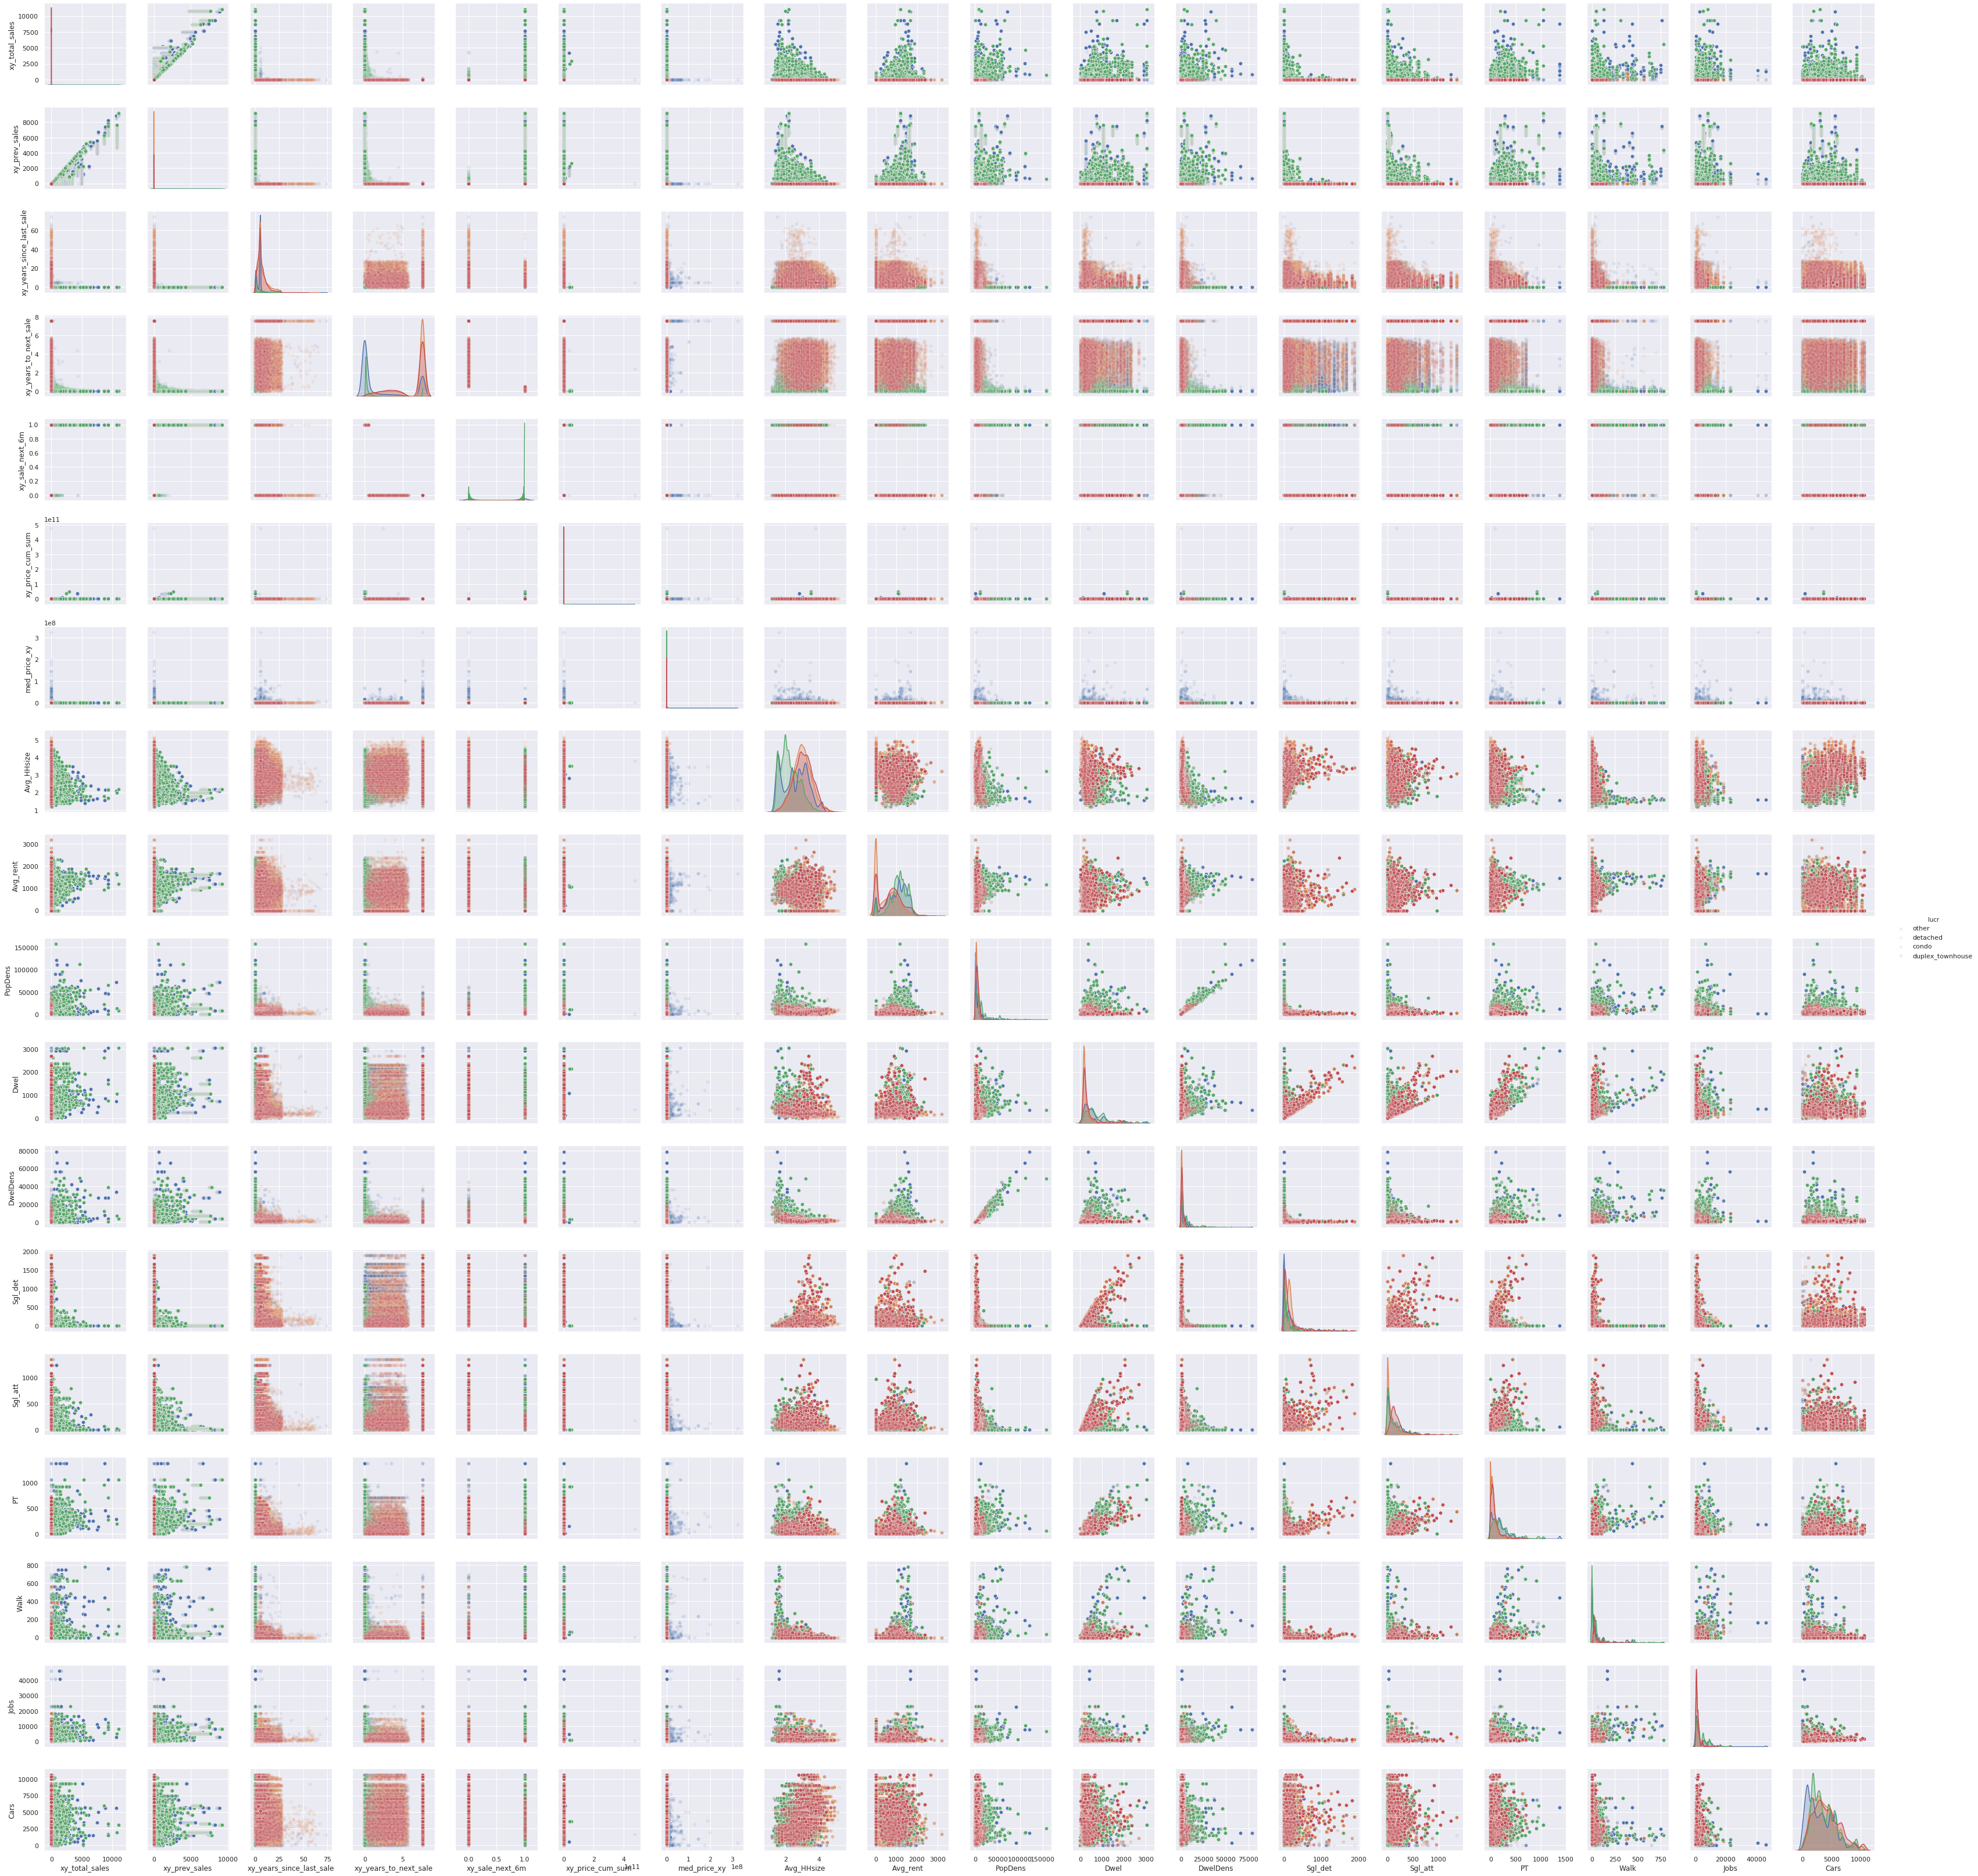

In [44]:
t = time()
pg = sns.pairplot(s[feat_cols.append(pd.Index(['lucr']))], hue='lucr', kind='scatter', plot_kws={'alpha': 0.1})
pg.savefig('results/plots/features/' + feat_set_name + '_pairplot.png', dpi=400)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                          var       variable     value
22           xy_sale_next_6m  lucr_detached -0.621854
3      xy_years_to_next_sale     lucr_condo -0.512346
26                  Avg_rent  lucr_detached -0.406608
2   xy_years_since_last_sale     lucr_condo -0.397538
18            xy_total_sales  lucr_detached -0.352595
7                 Avg_HHsize     lucr_condo -0.335255
19             xy_prev_sales  lucr_detached -0.324192
28                      Dwel  lucr_detached -0.311624
32                        PT  lucr_detached -0.295609
12                   Sgl_det     lucr_condo -0.276207 

         strongest positive correlation (top 10):
                          var       variable     value
21     xy_years_to_next_sale  lucr_detached  0.591852
4            xy_sale_next_6m     lucr_condo  0.571915
20  xy_years_since_last_sale  lucr_detached  0.549326
1          

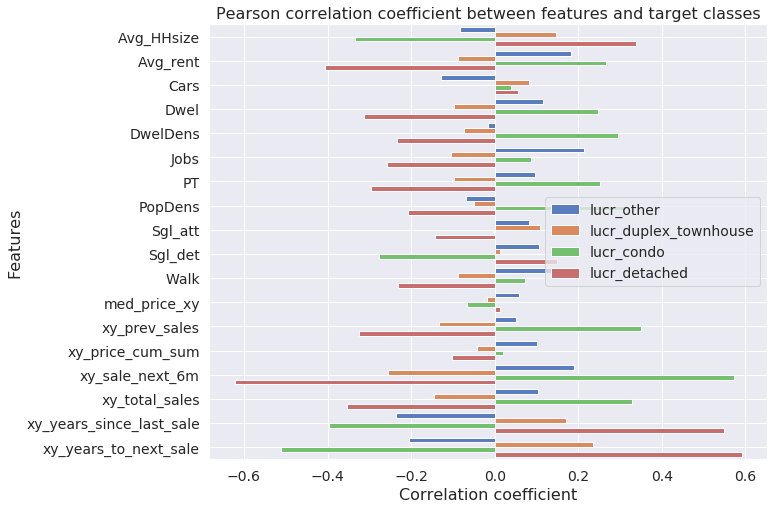

In [45]:
target_list = ['lucr_condo', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_other']
target_var = 'lucr'
save_path = 'results/plots/features/' + feat_set_name + '_lucr_corr.png'
targets_corr(s, target_list, target_var, fig_height=8, output='save', save_path=save_path)

## Encode target

In [25]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               55527
detached            59670
duplex_townhouse    13251
other               76257
Name: lucr, dtype: int64
0    55527
1    59670
2    13251
3    76257
Name: lucr_e, dtype: int64
condo               62648
detached            60403
duplex_townhouse    13709
other               81183
Name: lucr, dtype: int64
0    62648
1    60403
2    13709
3    81183
Name: lucr_e, dtype: int64
condo               48276
detached            57104
duplex_townhouse    12539
other               89336
Name: lucr, dtype: int64
0    48276
1    57104
2    12539
3    89336
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

#### Select features and target

In [ ]:
def prep_features_val(df, df_val1, df_val2, feat_cols, target_col, norm=True, std=True, 
                      random_state=random_state, test_size=0.3, stratify=True):
    
    X = df[feat_cols].values
    X_val1 = df_val1[feat_cols].values
    X_val2 = df_val2[feat_cols].values
    
    y = df[target_col].values
    y_val1 = df_val1[target_col].values
    y_val2 = df_val2[target_col].values
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            random_state=random_state, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print("Performed train-test split.")
    print('Labels counts in y:', np.bincount(y))
    print('Labels counts in y_train:', np.bincount(y_train))
    print('Labels counts in y_test:', np.bincount(y_test))
    print('Labels counts in y_val1:', np.bincount(y_val1))
    print('Labels counts in y_val2:', np.bincount(y_val2))

In [ ]:
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values

In [26]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform the train-test split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [55527 59670 13251 76257]
Labels counts in y_train: [38869 41769  9275 53380]
Labels counts in y_test: [16658 17901  3976 22877]
Labels counts in y_val1: [62648 60403 13709 81183]
Labels counts in y_val2: [48276 57104 12539 89336]


#### Standardize features

In [28]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [29]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


## Estimate model fit times

In [30]:
random_state = 1

### Perceptron

In [62]:
fit_times_df = pd.DataFrame()

In [63]:
eta = 0.22
max_iter = 100
n_jobs = 8
model_name = 'ppn'
model = Perceptron(random_state=random_state, eta0=eta, max_iter=max_iter, n_jobs=n_jobs)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

Model fit (8 jobs), took 2.03 seconds (0.03 minutes) in total.


### Logistic regression with L2 regularization

In [66]:
c = 0.1
penalty='l2'
n_jobs = 8
model_name = 'lr_{0}_c{1}'.format(penalty, c)

model = LogisticRegression(penalty=penalty, random_state=random_state, 
                           solver='lbfgs', multi_class='auto', C=c, n_jobs=n_jobs)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

Model fit (8 jobs), took 28.55 seconds (0.48 minutes) in total.


### Logistic regression with L1 regularization

In [68]:
c = 0.1
penalty='l1'
model_name = 'lr_{0}_c{1}'.format(penalty, c)

model = LogisticRegression(penalty=penalty, random_state=random_state, solver='liblinear', multi_class='auto', C=c)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model fit (8 jobs), took 1,182.07 seconds (19.70 minutes) in total.


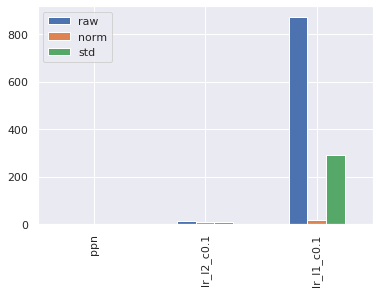

In [71]:
fit_times_df.plot(kind='bar')

In [95]:
def log_hist(series, bins=10, title='', yticks_sep=True):
    
    plt.subplot(211)
    hist, bins, _ = plt.hist(series, bins=bins)
    plt.title("Linear scale histogram {0}".format(title))
    ax = plt.gca()
    if yticks_sep:
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    
    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(series, bins=logbins)
    ax = plt.gca()
    plt.title("Log scale histogram {0}".format(title))
    plt.xscale('log')
    if yticks_sep:
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.tight_layout()
    plt.show()

## Outliers

### Temporal

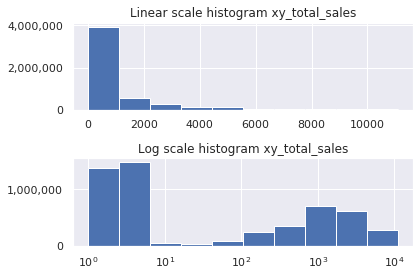

In [107]:
col_name = 'xy_total_sales'
log_hist(df[col_name], title=col_name)

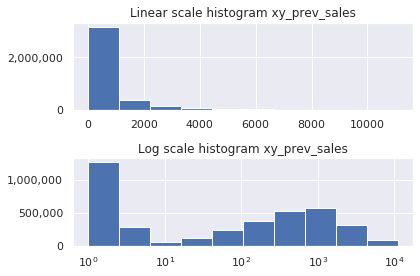

In [101]:
col_name = 'xy_prev_sales'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name)

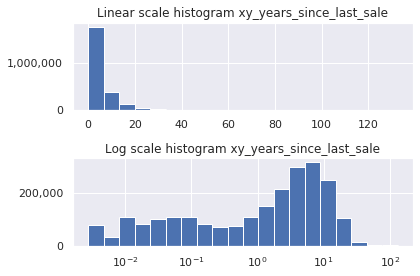

In [105]:
col_name = 'xy_years_since_last_sale'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=20)

### Price

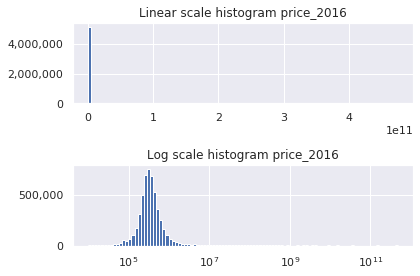

In [134]:
col_name = 'price_2016'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

In [148]:
np.abs(stats.zscore(df.loc[~mask2, col_name]))

array([0.01095982, 0.01095982, 0.01095982, ..., 0.00253738, 0.00335705,
       0.00216586])

In [146]:
mask3 = np.abs(stats.zscore(df[col_name])) < 3
mask3.sum()

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


0

In [ ]:
np.log

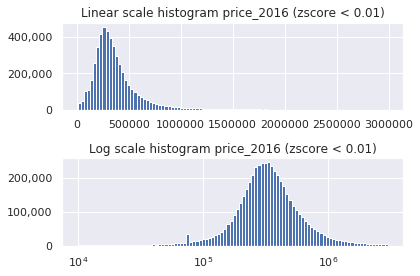

In [163]:
from scipy import stats

col_name = 'price_2016'
max_zscore = 0.01
mask1 = np.abs(stats.zscore(df[col_name].dropna())) < max_zscore
log_hist(df[col_name].dropna()[mask1], title=col_name + ' (zscore < {0})'.format(max_zscore), bins=100)

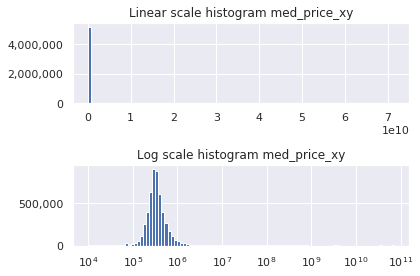

In [135]:
col_name = 'med_price_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

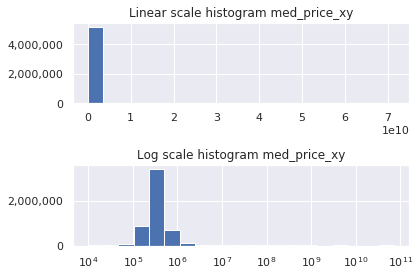

In [120]:
col_name = 'med_price_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=20)

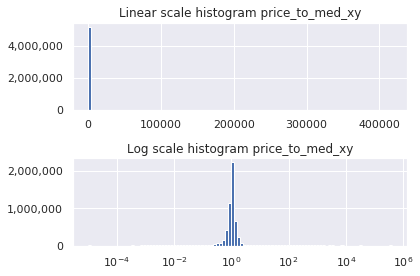

In [132]:
col_name = 'price_to_med_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

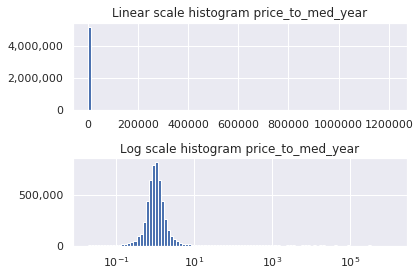

In [133]:
col_name = 'price_to_med_year'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)